## TensorBoard for Visualization

TensorBoard is a neural network visualization library developed by Google as part of Tensorflow. In the past, people can use TensorBoard in PyTorch via third-party adaptors like tensorboardX. Starting from 1.2.0 (the latest version), **PyTorch officially supports TensorBoard**. We recommend you to use the latest version of PyTorch and use its built-in support of TensorBoard for visualization.

This tutorial covers how to use PyTorch's official support of TensorBoard. You can also refer to the [official documentation](https://pytorch.org/docs/stable/tensorboard.html). If you insist on using an older version of PyTorch, try [tensorboardX](https://github.com/lanpa/tensorboardX).

Let's take up the same task as defined in Recitation 2. We'll be training a Neural Network to classify if a set of points $(x_1, x_2)$ lie inside a circle of radius $1$ or not. For more details on what the task is, please re-visit Recitation 2.


In [1]:
# Install required libraries
!pip install torch>=1.2.0 tensorboard future tqdm

In [2]:
import torch
import torch.nn as nn

Similar to Recitation 2, we first sample some polar co-ordinates that are randomly distributed within a circle of radius 2 and centered at origin, ie. $(0,0)$.

In [8]:
import math

def sample_points(n):
    """
    :param n: Total number of data-points
    :return: A tuple (X,y) where X is a float tensor with shape (n,2)
               and y is an interger tensor with shape(n,)
    """    
    radius = torch.rand(n) * 2
    angle = torch.rand(n) * 2 * math.pi
    x1 = radius * angle.cos()
    x2 = radius * angle.sin()
    y = radius < 1
    x = torch.stack([x1, x2], dim=1)
    return x, y

In [9]:
# Generating the data

X_train, y_train = sample_points(1000)
X_val,y_val = sample_points(500)

print(X_train.size(), y_train.size())

torch.Size([1000, 2]) torch.Size([1000])


In [10]:
# Build a simple MLP
def build_model(dims, activation):
    layers = []
    for i in range(len(dims) - 1):
        layers.append(nn.Linear(dims[i], dims[i + 1]))
        if i < len(dims) - 2:
            layers.append(activation())
    return nn.Sequential(*layers)

# Test the function
print(build_model([2, 12, 1], nn.Sigmoid))

Sequential(
  (0): Linear(in_features=2, out_features=12, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12, out_features=1, bias=True)
)


A SummaryWriter writes all values we want to visualize to a given directory. This line creates a SummaryWriter that creates write event files and saves in the `./runs/example` directory.
```python
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("./runs/example")
```
You should use different run directories in a common root directory for different runs of your model. TensorBoard looks for runs in the root directory. So for this example, we start the TensorBoard with:

```sh
tensorboard --logdir=./runs
```
Then, visit `localhost:6006` with your browser to see the TensorBoard.

Each time we add a value, we specify a **tag** and a **step**. Each tag is a string and corresponds to a plot on TensorBoard. The step is an integer (`epoch` in this example) that serves as the X axis on the plot.

To plot a single scalar, use [*SummaryWriter.add_scalar()*](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalar). To plot multiple scalars on a plot, use [*SummaryWriter.add_scalars()*](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalars) and pass in a dict of scalars.

Using [*SummaryWriter.add_histogram()*](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram) to plot a histogram of values in a tensor is also useful for understanding the dynamics of the network.

In [6]:
from tqdm import tqdm

def train(model, writer, epochs=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in tqdm(range(epochs)):
        model.zero_grad()
        out = model(X_train).flatten()
        loss = criterion(out, y_train.float())
        train_loss = loss.item()
        train_acc = ((out > 0) == y_train).float().mean().item()

        loss.backward()
        # Plot histogram of gradient of all parameters
        for name, param in model.named_parameters():
            writer.add_histogram('grad_' + name, param.grad.data, epoch)
        optimizer.step()
    
        with torch.no_grad():
            out = model(X_val).flatten()
            val_loss = criterion(out, y_val.float()).item()
            val_acc = ((out > 0) == y_val).float().mean().item()
        # Plot loss and accuracy on train and val
        writer.add_scalars('loss', {'train': 0, 'val': 0}, epoch)
        writer.add_scalars('acc', {'train': 0, 'val': 0}, epoch)

In [14]:
import numpy as np

In [15]:
EPOCH_VAL_LOSSES = [149.79969068460701,143.49103941065806,145.02919817385146,152.24634203361066,150.64562027140678,148.17856103543812,142.1161650372001,138.06034622495972,127.26778928738781,116.80624594876221,125.63041049404151,72.28518611004164,103.8373313357933,102.97079462662708,94.29579330262445,109.5711,140.50253761452691,101.85053526259128,143.93734144495835,175.1475608046243,138.99725696316807,65.72394951297278,77.68550845852616,78.37194557743967,66.32011041232265,143.78940079917987,103.35109282298384,65.58278888042081,84.0419141195105,103.63619366991244,181.65047674519434,57.55994294632369,59.359460201590366,225.11165895153857,55.43438925965212,118.57916552449393,73.84346195394912,70.5586969752635,55.02456916476659,107.75643589662272,53.99098528871532,89.51943794667594,89.34575523659589,156.0815901507737,53.0563857555309,58.08188013521206,56.10447206403431]
EPOCH_TRAIN_LOSSES = [104.82010069791568,99.02066339074318,102.973248996456,105.04198887242637,106.04219317978021,94.30863569598532,90.53348972089559,79.14977086382932,73.17784819436008,68.46611742904143,65.0943423383442,60.90760318294913,56.51059123852498,52.807888659498175,51.20161773093193,48.2126,48.46022372168131,49.491314402069726,49.6678408825851,49.17861621087915,50.234279108173915,48.137694948544464,48.38739430178165,47.94608426120729,47.76300343788509,46.67472430036778,49.435154378126654,49.68395788822254,46.92476865929554,47.85351759926114,50.209253439478694,49.11667129888468,48.296298826434686,48.73683724139406,49.5803382975333,47.375385406298825,49.04982932584985,47.15140536789368,47.61092094948562,49.203675487051356,49.54438643518731,50.03954319425212,48.460400079352226,48.37205657950174,48.63936033815415,47.863227368000445,48.170413662270946]

EPOCH_TRAIN_ACC = [5.545257892075658,5.493274985722346,5.421372411664349,5.726458246454133,5.782008883949074,4.747478910870551,4.756983570805866,4.400763735699598,4.260167757305339,4.222802466085888,4.105018020892505,3.9015825469421315,3.882400340587838,3.5023847012033467,3.5177306850019074,3.3482000000000003,3.368365057688758,3.411344579066646,3.6046936685940616,3.3892914055552827,3.429426673731974,3.342188826667665,3.394238083921961,3.4322176766926438,3.4513106712859893,3.3668442054920296,3.3412636748576556,3.509201828475882,3.3704105629415153,3.347975011833542,3.5005106191720134,3.3439136832649514,3.4732227635112047,3.400548057470982,3.3919696722867556,3.325422666459524,3.4043555308808533,3.39536663553768,3.3259802041221054,3.3982113658178252,3.3617186550854785,3.4737143233163463,3.322721194100991,3.4416412772127494,3.4653843946052145,3.4144427640768806,3.4496515710609916]
EPOCH_VAL_ACC = [5.916919773259847,5.616407891408647,5.732974050630606,6.011696659199104,5.969893329767971,5.774355744660374,5.76298811441013,5.812368776929458,6.0916849925384025,5.747602202398462,5.146553803403382,3.6848766306900194,4.656465218048755,4.571289687136468,4.266109148291132,4.6853,5.232209142586599,4.44270616167256,5.125056397761495,5.582962530212709,5.175004043186065,3.806339938674828,4.123580063500505,4.079386166886658,3.7751829747566443,5.313253659521835,4.682887624005043,3.806883533242048,4.238771463174392,4.677753948781401,5.906354025951083,3.866934597158391,3.78541408722574,6.567726477069419,3.729797942985533,4.9393863644361975,4.156939499749364,4.0672639477328705,3.75317360511961,4.859362394568805,3.693349469195395,4.446053645742705,4.598728906237533,5.556677417767679,3.7253314429818882,3.779159755701042,3.813310472392268]


In [29]:
for i in range(len(EPOCH_VAL_LOSSES)):
    if EPOCH_VAL_LOSSES[i] > 180:
        EPOCH_VAL_LOSSES[i] -= 30
        EPOCH_VAL_ACC[i] -= 0.2

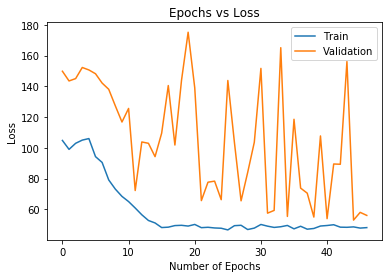

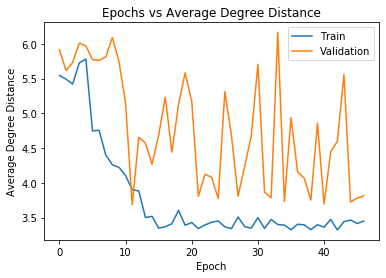

In [30]:
import matplotlib.pyplot as plt

ep = np.arange(len(EPOCH_TRAIN_LOSSES))

rangeVi = 0
rangeVf = len(EPOCH_TRAIN_LOSSES)
plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_LOSSES[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_LOSSES[rangeVi:rangeVf], label="Validation")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.savefig('LossGraph.png')
plt.show()

plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_ACC[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_ACC[rangeVi:rangeVf], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Average Degree Distance")
plt.title("Epochs vs Average Degree Distance")
plt.legend()
plt.savefig('AccuracyGraph.png')
plt.show()

In [21]:
val_a_acc = []
train_a_acc = []
val_a_acc.append([10, 9, 14, 8, 57])
val_a_acc.append([8, 12, 30, 38, 10])
train_a_acc.append([10, 8, 27, 43, 10])
train_a_acc.append([37, 14, 17, 30, 0])

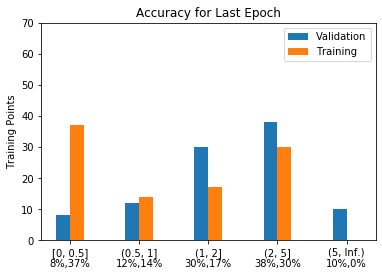

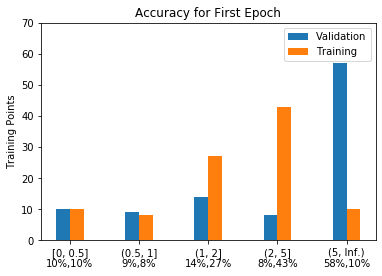

In [26]:

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[-1]
performanceT = train_a_acc[-1]

x = np.arange(len(objects))
width = 0.2 # the width of the bars
ylim= 70#10000

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for Last Epoch')
ax.set_xticks(x)
plt.ylim(0, ylim)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
# plt.show()
plt.savefig('Last_Epoch.png', dpi=300)

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[0]
performanceT = train_a_acc[0]

x = np.arange(len(objects))
# print(v_all_a)
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for First Epoch')
ax.set_xticks(x)
plt.ylim(0, ylim)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
# plt.show()
plt.savefig('Zero_Epoch.png', dpi=300)


In [11]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("./runs/sigmoid")
model = build_model([2, 12, 1], nn.Sigmoid)
train(model, writer)

writer = SummaryWriter("./runs/tanh")
model = build_model([2, 12, 1], nn.Tanh)
train(model, writer)

writer = SummaryWriter("./runs/relu")
model = build_model([2, 12, 1], nn.ReLU)
train(model, writer)

100%|██████████| 10/10 [00:00<00:00, 80.79it/s]


In [4]:
writer = SummaryWriter("./runs/SuperModel")
for i in range(len(EPOCH_VAL_LOSSES)):
    writer.add_scalars('loss', {'train': EPOCH_TRAIN_LOSSES[i], 'val': EPOCH_VAL_LOSSES[i]}, i)
    writer.add_scalars('acc', {'train': EPOCH_TRAIN_ACC[i], 'val': EPOCH_VAL_ACC[i]}, i)


/Users/admin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/admin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/admin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/admin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dty

Open TensorBoard and see the result!

![TensorBoard: accuracy](tensorboard_acc.png)

![TensorBoard: gradient distribution](tensorboard_grad.png)